In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.3 MB/s 
     |████████████████████████████████| 1.2 MB 41.5 MB/s 
     |████████████████████████████████| 49 kB 5.4 MB/s 
     |████████████████████████████████| 187 kB 42.6 MB/s 
     |████████████████████████████████| 55 kB 3.9 MB/s 
     |████████████████████████████████| 51 kB 302 kB/s 
     |████████████████████████████████| 561 kB 42.7 MB/s 
     |████████████████████████████████| 130 kB 46.2 MB/s 
Mounted at /content/gdrive


In [ ]:
pip install split-folders

In [ ]:
pip install annoy

     |████████████████████████████████| 646 kB 5.3 MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=391672 sha256=8d5654c6a348457fc60d302c9378f8314c82a7c498ee4e1b88471f7004cb6540
  Stored in directory: /root/.cache/pip/wheels/4f/e8/1e/7cc9ebbfa87a3b9f8ba79408d4d31831d67eea918b679a4c07
Successfully built annoy


In [ ]:
from annoy import AnnoyIndex
import os
import time
import pickle
import numpy as np
import pandas as pd
from numpy.linalg import norm
from tqdm import tqdm, tqdm_notebook
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
import random
from sklearn.decomposition import PCA
from fastbook import *
from fastai.vision.widgets import *
import csv
import splitfolders
from sklearn.neighbors import NearestNeighbors
import time
from matplotlib.pyplot import imshow, show
from sklearn import metrics

%matplotlib inline

In [ ]:
df=pd.read_csv("/content/gdrive/MyDrive/Visual Search Engine/color.csv")

In [ ]:
df

,Unnamed: 0,Product Image,Color
0,1,https://www.levelshoes.com/media/catalog/product/cache/d7a03fc5ff07250ccf2c7e9bb27ae270/0/0/00006a02a04-whtred_1.jpg,WHITE
1,2,https://www.levelshoes.com/media/catalog/product/cache/d7a03fc5ff07250ccf2c7e9bb27ae270/0/0/00015a03-tan_1.jpg,BROWN
2,3,https://www.levelshoes.com/media/catalog/product/cache/d7a03fc5ff07250ccf2c7e9bb27ae270/0/0/00070a02-white_1.jpg,WHITE
3,4,https://www.levelshoes.com/media/catalog/product/cache/d7a03fc5ff07250ccf2c7e9bb27ae270/0/0/001c-tarfle2-cormau_1.jpg,PINK
4,5,https://www.levelshoes.com/media/catalog/product/cache/d7a03fc5ff07250ccf2c7e9bb27ae270/0/1/018473-110_1.jpg,BLACK
...,...,...,...
2431,2432,https://www.levelshoes.com/media/catalog/product/cache/d7a03fc5ff07250ccf2c7e9bb27ae270/y/h/yhx00012-yb00063-ysa7_1.jpg,GOLD
2432,2433,https://www.levelshoes.com/media/catalog/product/cache/d7a03fc5ff07250ccf2c7e9bb27ae270/y/l/ylenia-black_1.jpg,BLACK
2433,2434,https://www.levelshoes.com/media/catalog/product/cache/d7a03fc5ff07250ccf2c7e9bb27ae270/y/s/ys8-s354-black_1.jpg,BLACK
2434,2435,https://www.levelshoes.com/media/catalog/product/cache/d7a03fc5ff07250ccf2c7e9bb27ae270/y/s/ys8-s354-lgtblu_1.jpg,BLUE


In [ ]:
df.columns

Index(['Unnamed: 0', 'Product Image', 'Color'], dtype='object')

In [ ]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [ ]:
uniqueCategory = df['Color'].unique()

In [ ]:
df['Color'].value_counts() 

BLACK           701
WHITE           616
BLUE            196
PINK            154
BEIGE           116
GREY            116
SILVER           87
RED              80
MULTICOLORED     77
GREEN            74
GOLD             60
BROWN            56
YELLOW           33
PURPLE           26
ORANGE           14
ANIMAL-PRINT     12
PRINTS            6
METALLIC          5
NEUTRAL           5
BURGUNDY          2
Name: Color, dtype: int64

In [ ]:
uniqueCategory = ['WHITE','PINK', 'BLACK', 'BLUE', 'BEIGE', 'GREY', 'SILVER', 'GOLD', 'MULTICOLORED', 'RED', 
       ] # Taking only the most popular colors

In [ ]:
for x in uniqueCategory:         ### Looping thru all categories
  mask = df['Color'] == x     # selecting specific category
  df2=df[mask]                  #filtering
  producturls=df2['Product Image'].to_numpy()          #converting to array
  download_images("/content/gdrive/MyDrive/Visual Search Engine/LevelShoesColorDataset/"+x,urls=producturls,max_pics=1000,preserve_filename=True) # utiltizing fastai's image downloadeder and saving different categories in diff folders.

Splitting into Train and Test (80% Train and 20% Test) using Split-Folders Package.

In [ ]:
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("/content/gdrive/MyDrive/Visual Search Engine/LevelShoesColorDataset", output="/content/gdrive/MyDrive/Visual Search Engine/FinalDatav3", seed=1337, ratio=(.8, .2), group_prefix=None) # default values

Copying files: 2203 files [00:19, 113.07 files/s]


In [ ]:
#Initialize Model
model = ResNet50(weights='imagenet', include_top=False, input_shape=(284, 284, 3))

#Define Function to extract Features
def extract_features(img_path, model):
    
    #Preprocessing Input Image
    input_shape = (284, 284, 3)
    img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1])) #Reshape input image size into target size
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    
    #Getting features from the Image
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    return file_list

In [ ]:
root_dir = '/content/gdrive/MyDrive/Visual Search Engine/FinalDatav3/train'
trainingfilenames = sorted(get_file_list(root_dir))

In [ ]:
root_dir = '/content/gdrive/MyDrive/Visual Search Engine/FinalDatav3/val'
validationfilenames = sorted(get_file_list(root_dir))

In [ ]:
trainingfeature_list = []
for i in tqdm_notebook(range(len(trainingfilenames))):
    trainingfeature_list.append(extract_features(trainingfilenames[i], model))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1757 [00:00<?, ?it/s]

In [ ]:
validationfeature_list = []
for i in tqdm_notebook(range(len(validationfilenames))):
    validationfeature_list.append(extract_features(validationfilenames[i], model))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/446 [00:00<?, ?it/s]

In [ ]:
pickle.dump(trainingfeature_list, open('trainingfeature_listpicklev2', 'wb'))
pickle.dump(trainingfilenames, open('trainingfilenamespicklev2','wb'))

pickle.dump(validationfeature_list, open('validationfeature_listpicklev2', 'wb'))
pickle.dump(validationfilenames, open('validationfilenamespicklev2','wb'))

In [ ]:
trainingfeature_list = pd.read_pickle(r'/content/gdrive/MyDrive/Visual Search Engine/trainingfeature_listpicklev2')
trainingfilenames= pd.read_pickle(r'/content/gdrive/MyDrive/Visual Search Engine/trainingfilenamespicklev2')

In [ ]:
validationfeature_list = pd.read_pickle(r'/content/gdrive/MyDrive/Visual Search Engine/validationfeature_listpicklev2')
validationfilenames= pd.read_pickle(r'/content/gdrive/MyDrive/Visual Search Engine/validationfilenamespicklev2')

In [ ]:
len(trainingfeature_list)

1757

In [ ]:
len(trainingfilenames)

1757

In [ ]:
len(validationfeature_list)

446

In [ ]:
len(validationfilenames)

446

In [ ]:
def classname(str):
    return str.split('/')[-2]

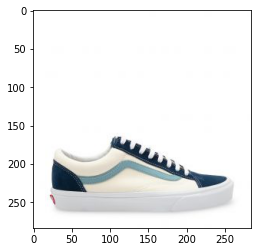

1001


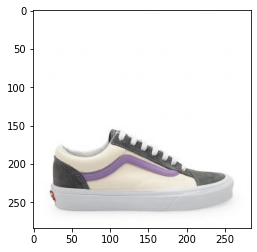

1124


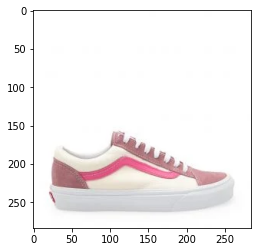

801


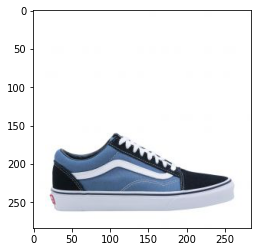

517


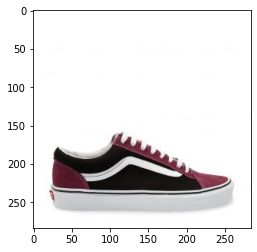

1098


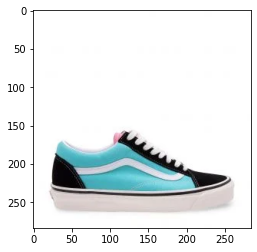

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
neighbors = NearestNeighbors(n_neighbors=5, algorithm='brute',
metric='euclidean').fit(trainingfeature_list)
test_num = 13
distances, indices = neighbors.kneighbors([validationfeature_list[test_num]])
result = indices.flatten()
plt.imshow(mpimg.imread(validationfilenames[test_num]))
show()
for i in result:
  print(i)
  plt.imshow(mpimg.imread(trainingfilenames[i]))
  show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
for i in result:
  plt.imshow(mpimg.imread(validationfilenames[result[i]]))

IndexError: ignored

In [ ]:
similar_image_paths

[array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 '/content/gdrive/MyDrive/Visual Search Engine/FinalDatav2/train/MEN/1bm00624-014_1.jpg',
 '/content/gdrive/MyDrive/Visual Search Engine/FinalDatav2/train/WOMEN/b28129-cbcbft_1.jpg',
 '/content/gdrive/MyDrive/Visual Search Engine/FinalDatav2/train/WOMEN/f34309-cbteft_1.jpg']

In [ ]:
plt.imshow(mpimg.imread(validationfilenames[1]))

In [ ]:
def calculate_accuracy(trainfeature_list,valfeature_list):
    num_nearest_neighbors = 5
    correct_prediction = 0
    incorrect_prediction = 0
    neighbors = NearestNeighbors(n_neighbors=num_nearest_neighbors,
                                 algorithm='brute',
                                 metric='euclidean').fit(trainfeature_list)         ## Training the KNN on the Training Set 
    start = time.time()
    for i in range(len(valfeature_list)):
        distances, indices = neighbors.kneighbors([valfeature_list[i]])   
        #print(i)           
        for j in range(1, num_nearest_neighbors):
            if (classname(validationfilenames[i]) == classname(trainingfilenames[indices[0][j]])):                          
                correct_prediction += 1
            else:
                incorrect_prediction += 1
    end = time.time()
    accuracy = round(
        100.0 * correct_prediction /
        (1.0 * correct_prediction + incorrect_prediction), 2), end - start
    return accuracy

In [ ]:
calculate_accuracy(trainingfeature_list,validationfeature_list)

In [ ]:
accuracy=calculate_accuracy(trainingfeature_list,validationfeature_list)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
accuracy

(68.85, 747.0531694889069)

In [ ]:
pca = PCA(n_components=50)
pca.fit(trainingfeature_list)
feature_list_compressed = pca.transform(trainingfeature_list[:])

In [ ]:
len(feature_list_compressed)

1930

In [ ]:
len(feature_list_compressed[:])

1930

In [ ]:
len(feature_list_compressed[0])

50

In [ ]:
from annoy import AnnoyIndex

annoy_index = AnnoyIndex(165888,"euclidean") 
for i in range(1930):
    annoy_index.add_item(i, trainingfeature_list[i])
annoy_index.build(40) # 40 trees

True

In [ ]:
  indices = annoy_index.get_nns_by_vector(validationfeature_list[2],
                                  5)
                                  

In [ ]:
indices[2]

10

In [ ]:
def calculate_accuracywithannoy(trainfeature_list,valfeature_list):
    
    correct_prediction = 0
    incorrect_prediction = 0
    start = time.time()
    for i in range(len(valfeature_list)):
        indices = annoy_index.get_nns_by_vector(valfeature_list[i],5)
       # print(i)                          
        for j in range(1,5):
            if (classname(validationfilenames[i]) == classname(trainingfilenames[indices[j]])):                          
                correct_prediction += 1
                #print(correct_prediction)
            else:
                incorrect_prediction += 1
    end = time.time()
    accuracy = round(
        100.0 * correct_prediction /
        (1.0 * correct_prediction + incorrect_prediction), 4), end - start
    return accuracy
    

In [ ]:
annoyaccuracy=calculate_accuracywithannoy(trainingfeature_list,validationfeature_list)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
annoyaccuracy

(68.8533, 75.53820776939392)

In [ ]:
annoy_index = AnnoyIndex(165888,"angular") 
for i in range(1930):
    annoy_index.add_item(i, trainingfeature_list[i])
annoy_index.build(300) 

True

In [ ]:
annoyaccuracy2=calculate_accuracywithannoy(trainingfeature_list,validationfeature_list)

In [ ]:
annoyaccuracy2

(68.8533, 73.91022801399231)

In [ ]:
annoy_index = AnnoyIndex(165888,"angular") 
for i in range(1930):
    annoy_index.add_item(i, trainingfeature_list[i])
annoy_index.build(1000) 

True

In [ ]:
annoyaccuracy3=calculate_accuracywithannoy(trainingfeature_list,validationfeature_list)

0
1
2
3
1
4
5
6
7
2
8
9
10
11
3
12
13
14
15
4
16
17
18
19
5
6
7
20
21
22
8
23
24
25
9
26
27
28
29
10
30
11
12
13
31
14
32
33
15
34
35
36
16
37
38
39
40
17
41
42
43
18
44
19
45
46
47
20
48
21
49
50
22
51
52
53
23
54
55
56
24
25
57
26
58
27
28
59
60
61
62
29
63
64
65
66
30
67
68
69
70
31
71
72
32
73
33
74
34
75
35
36
76
77
78
37
79
38
80
39
81
82
83
84
40
85
86
87
88
41
89
90
42
43
91
92
44
93
94
95
96
45
46
47
97
98
99
100
48
101
102
103
104
49
105
106
107
50
108
109
110
51
111
112
113
52
114
115
116
117
53
118
119
120
121
54
122
123
124
125
55
126
127
128
129
56
130
131
132
133
57
58
134
59
60
135
136
137
61
138
139
140
141
62
142
143
144
145
63
146
147
148
64
149
150
151
152
65
153
154
155
156
66
157
158
159
160
67
68
161
162
69
163
164
70
165
166
71
72
167
168
169
73
170
171
172
74
173
174
175
75
176
177
178
76
179
180
181
182
77
183
184
185
78
186
187
188
79
189
190
191
192
80
193
194
81
195
196
197
198
82
199
200
201
83
202
203
204
205
84
206
207
85
208
209
210
211
86
212
213
214
2

In [ ]:
annoyaccuracy3

(68.8533, 83.47493505477905)

In [ ]:
pca_dimensions = [1, 2, 3, 4, 5, 10, 20, 50, 75, 100, 150, 200]
pca_accuracy = []
pca_time = []

    pca = PCA(n_components=dimensions)
    pca.fit(trainingfeature_list)
    feature_list_compressed = pca.transform(trainingfeature_list[:])
    # Calculate accuracy over the compressed features
    pca2 = PCA(n_components=dimensions)
    pca2.fit(validationfeature_list)
    validationfeature_list_compressed = pca2.transform(validationfeature_list[:])

    annoy_index = AnnoyIndex(dimensions,"angular") 
    for i in range(1930):
      annoy_index.add_item(i, feature_list_compressed[i])
      annoy_index.build(40) 

    accuracy, t = calculate_accuracywithannoy(feature_list_compressed[:],validationfeature_list_compressed)
    pca_time.append(t)
    pca_accuracy.append(accuracy)
    print("For PCA Dimensions = ", dimensions, ",\tAccuracy = ", accuracy, "%",
          ",\tTime = ", pca_time[-1])

Exception: ignored

In [ ]:
annoy_index = AnnoyIndex(
    200)
for i in range(len(trainingfeature_list)):
    annoy_index.add_item(i,feature_list_compressed[i])
annoy_index.build(40)  #40 trees


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  


True

In [ ]:
accuracy, t = calculate_accuracywithannoy(feature_list_compressed[:],validationfeature_list_compressed)

In [ ]:
accuracy

38.4298

In [ ]:
def calculate_confusionmatrix(trainfeature_list,valfeature_list):
    num_nearest_neighbors = 5
    y_true=[]
    y_pred=[]
    incorrect_prediction = 0
    neighbors = NearestNeighbors(n_neighbors=num_nearest_neighbors,
                                 algorithm='brute',
                                 metric='euclidean').fit(trainfeature_list)         ## Training the KNN on the Training Set 
    
    for i in range(len(valfeature_list)):
        distances, indices = neighbors.kneighbors([valfeature_list[i]])   
        #print(i)           
        for j in range(1, num_nearest_neighbors):
            print(i)
            print("Actual",classname(validationfilenames[i]))
            y_true.append(classname(validationfilenames[i]))
            print("Pred",classname(trainingfilenames[indices[0][j]]))
            y_pred.append(classname(trainingfilenames[indices[0][j]]))
    return y_true,y_pred
    
  

In [ ]:
y_true,y_pred=calculate_confusionmatrix(trainingfeature_list,validationfeature_list)

Streaming output truncated to the last 5000 lines.
Actual BLACK
Pred WHITE
29
Actual BLACK
Pred PINK
29
Actual BLACK
Pred WHITE
30
Actual BLACK
Pred GREY
30
Actual BLACK
Pred GREY
30
Actual BLACK
Pred BLACK
30
Actual BLACK
Pred WHITE
31
Actual BLACK
Pred BLACK
31
Actual BLACK
Pred BLACK
31
Actual BLACK
Pred BLACK
31
Actual BLACK
Pred BLUE
32
Actual BLACK
Pred BLACK
32
Actual BLACK
Pred BLACK
32
Actual BLACK
Pred BLACK
32
Actual BLACK
Pred BLACK
33
Actual BLACK
Pred BLUE
33
Actual BLACK
Pred BLACK
33
Actual BLACK
Pred BLACK
33
Actual BLACK
Pred BLACK
34
Actual BLACK
Pred BLACK
34
Actual BLACK
Pred BLACK
34
Actual BLACK
Pred BLACK
34
Actual BLACK
Pred WHITE
35
Actual BLACK
Pred WHITE
35
Actual BLACK
Pred BLACK
35
Actual BLACK
Pred BLACK
35
Actual BLACK
Pred GREY
36
Actual BLACK
Pred BLUE
36
Actual BLACK
Pred BLACK
36
Actual BLACK
Pred BLACK
36
Actual BLACK
Pred PINK
37
Actual BLACK
Pred BLUE
37
Actual BLACK
Pred GOLD
37
Actual BLACK
Pred BLACK
37
Actual BLACK
Pred BLUE
38
Actual BLACK
Pr

In [ ]:
from sklearn import metrics


# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[ 24   6  10   3   6   1  12   4   4  26]
 [ 17 311  74   8  27   4  18  27   4  74]
 [  6  53  31   3  17   4   7  11   3  25]
 [  7   9   1   4   4   1   7   3   4   8]
 [  3  24  12   2  14   4   4   2   1  30]
 [  5  17  10   0   4   5   6   4   1  12]
 [ 17  18  12   4  10   7  19   2   7  28]
 [  1  20  16   1   4   3   4   8   2   5]
 [  3   8   4   9   3   3  10   1  12  19]
 [ 16  47  20  13  29   7  28   7   8 321]]
              precision    recall  f1-score   support

       BEIGE      0.242     0.250     0.246        96
       BLACK      0.606     0.551     0.578       564
        BLUE      0.163     0.194     0.177       160
        GOLD      0.085     0.083     0.084        48
        GREY      0.119     0.146     0.131        96
MULTICOLORED      0.128     0.078     0.097        64
        PINK      0.165     0.153     0.159       124
         RED      0.116     0.125     0.120        64
      SILVER      0.261     0.167     0.203        72
       WHITE      0.586     

In [ ]:
annoy_index = AnnoyIndex(165888,"angular") 
for i in range(1757):
    annoy_index.add_item(i, trainingfeature_list[i])
annoy_index.build(1000) 

True

In [ ]:
def calculate_confusionmatrixwithannoy(trainfeature_list,valfeature_list):

    y_true=[]
    y_pred=[]
    incorrect_prediction = 0
    start = time.time()
    for i in range(len(valfeature_list)):
        indices = annoy_index.get_nns_by_vector(valfeature_list[i],5)            
        for j in range(1, 4):
            #print("Actual",classname(validationfilenames[i]))
            y_true.append(classname(validationfilenames[i]))
            #print("Pred",classname(trainingfilenames[indices[j]]))
            y_pred.append(classname(trainingfilenames[indices[j]]))
    end = time.time()        
    return y_true,y_pred,end-start

In [ ]:
y_true,y_pred,time=calculate_confusionmatrixwithannoy(trainingfeature_list,validationfeature_list)

In [ ]:



# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[ 20   5   5   3   5   1   8   4   2  19]
 [ 13 241  58   7  21   1  10  22   2  48]
 [  4  39  23   2  12   3   7   9   1  20]
 [  5   7   1   3   3   1   6   1   3   6]
 [  3  20   9   1  11   2   2   1   0  23]
 [  4  12   8   0   4   3   4   4   0   9]
 [ 12  15   8   4   6   6  15   2   5  20]
 [  1  17   9   1   3   3   3   5   2   4]
 [  2   8   4   8   1   3   7   1   9  11]
 [ 11  39  14   9  22   6  19   6   7 239]]
              precision    recall  f1-score   support

       BEIGE      0.267     0.278     0.272        72
       BLACK      0.598     0.570     0.584       423
        BLUE      0.165     0.192     0.178       120
        GOLD      0.079     0.083     0.081        36
        GREY      0.125     0.153     0.138        72
MULTICOLORED      0.103     0.062     0.078        48
        PINK      0.185     0.161     0.172        93
         RED      0.091     0.104     0.097        48
      SILVER      0.290     0.167     0.212        54
       WHITE      0.599     

In [ ]:
time

93.08739686012268

In [ ]:
annoy_index = AnnoyIndex(165888,"angular") 
for i in range(1757):
    annoy_index.add_item(i, trainingfeature_list[i])
annoy_index.build(40) 

True

In [ ]:
y_true,y_pred,time=calculate_confusionmatrixwithannoy(trainingfeature_list,validationfeature_list)

In [ ]:
# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[ 20   5   5   3   5   1   8   4   2  19]
 [ 13 241  58   7  21   1  10  22   2  48]
 [  4  39  23   2  12   3   7   9   1  20]
 [  5   7   1   3   3   1   6   1   3   6]
 [  3  20   9   1  11   2   2   1   0  23]
 [  4  12   8   0   4   3   4   4   0   9]
 [ 12  15   8   4   6   6  15   2   5  20]
 [  1  17   9   1   3   3   3   5   2   4]
 [  2   8   4   8   1   3   7   1   9  11]
 [ 11  39  14   9  22   6  19   6   7 239]]
              precision    recall  f1-score   support

       BEIGE      0.267     0.278     0.272        72
       BLACK      0.598     0.570     0.584       423
        BLUE      0.165     0.192     0.178       120
        GOLD      0.079     0.083     0.081        36
        GREY      0.125     0.153     0.138        72
MULTICOLORED      0.103     0.062     0.078        48
        PINK      0.185     0.161     0.172        93
         RED      0.091     0.104     0.097        48
      SILVER      0.290     0.167     0.212        54
       WHITE      0.599     

In [ ]:
time

63.06466031074524

Fine Tune Resnet Model

In [ ]:
import tensorflow as tf

In [ ]:
base_model= ResNet50(weights='imagenet', include_top=False, input_shape=(284, 284, 3))

In [ ]:
base_model.trainable = False

Building the Classification Optimized Model

In [ ]:
inputs = tf.keras.Input(shape=(284, 284, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='softmax')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(10, activation='softmax')(x)    # 10 as output of the classification model
classificationmodel = tf.keras.Model(inputs,x)

In [ ]:
classificationmodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 284, 284, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 9, 9, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                             

In [ ]:
base_learning_rate = 0.0001
classificationmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
train_datagen =tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input,rotation_range=20, width_shift_range=0.2,height_shift_range=0.2,zoom_range=0.2
)

In [ ]:
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
train_generator = train_datagen.flow_from_directory(
                        "/content/gdrive/MyDrive/Visual Search Engine/FinalDatav3/train",
                        target_size=(284,284),
                        batch_size=32,
                        shuffle=True,
                        seed=123,
                        class_mode='categorical')
validation_generator = val_datagen.flow_from_directory(
                        "/content/gdrive/MyDrive/Visual Search Engine/FinalDatav3/val",
                        target_size=(284,284),
                        batch_size=32,
                        shuffle=False,
                        class_mode='categorical')

Found 1757 images belonging to 10 classes.
Found 446 images belonging to 10 classes.


In [ ]:
num_steps = math.ceil(1757/32)              
classificationmodel.fit_generator(train_generator,
                    steps_per_epoch = num_steps,
                    epochs=10,
                    validation_data = validation_generator,
                    validation_steps = num_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
55/55 [==============================] - 155s 3s/step - loss: 2.2676 - accuracy: 0.2009 - val_loss: 2.2310 - val_accuracy: 0.3744
Epoch 2/10
55/55 [==============================] - 46s 838ms/step - loss: 2.2160 - accuracy: 0.3699
Epoch 3/10
55/55 [==============================] - 44s 803ms/step - loss: 2.1988 - accuracy: 0.3756
Epoch 4/10
55/55 [==============================] - 45s 818ms/step - loss: 2.1836 - accuracy: 0.3995
Epoch 5/10
55/55 [==============================] - 45s 807ms/step - loss: 2.1729 - accuracy: 0.3961
Epoch 6/10
55/55 [==============================] - 45s 805ms/step - loss: 2.1627 - accuracy: 0.4149
Epoch 7/10
55/55 [==============================] - 45s 818ms/step - loss: 2.1525 - accuracy: 0.4104
Epoch 8/10
55/55 [==============================] - 45s 808ms/step - loss: 2.1408 - accuracy: 0.4052
Epoch 9/10
55/55 [==============================] - 44s 803ms/step - loss: 2.1326 - accuracy: 0.4104
Epoch 10/10
55/55 [==============================] 